In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import IPython.display

plt.rcParams['font.family'] = ["D2Coding"]

NOTEBOOK_ID = "MEMBRANE_POTENTIAL"
OUTPUT_PATH = f"out/{NOTEBOOK_ID}/"

if not os.path.isdir(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

# 막전위

## 확산 방정식과 막

## Goldman-Hodgkin-Katz Voltage Equation(more commonly, Goldman Equation)

대강

$$V_m = 61\log\frac{P_\text{Na}[\text{Na}^+]_\text{o}+P_\text{K}[\text{K}^+]_\text{o}}{P_\text{Na}[\text{Na}^+]_\text{i}+P_\text{K}[\text{K}^+]_\text{i}}$$


## 모델 구성

* 공간
    * 막
        * 채널(막투과도 조정)
        * 펌프

In [2]:
class Space:
    def __init__(self, t, dt, domain, dx, ion_size=2, D=0.1):
        self.D = D
        self.domain = domain
        self.dx = dx
        self.t = t
        self.dt = dt
        self.ion_size = ion_size
        self.n = np.empty((len(t), self.ion_size, len(domain)))
        
        self.r = D * dt / dx ** 2
        
        self.membranes = []

    def render(self):
        # normal bound
        for it in range(0, len(self.t) - 1):
            [membrane.event(self.t[it]) for membrane in self.membranes]
            
            for ix in range(1, len(domain) - 1):
                for membrane in self.membranes:
                    if membrane.check_is_in_membrane(domain[ix]):
                        for ion in range(self.ion_size):
                            D = membrane.permeability_for(ion)
                            self.n[it + 1, ion, ix] = self.n[it, ion, ix] + (D * dt / dx ** 2) * (
                                    self.n[it, ion, ix + 1] - 2 * self.n[it, ion, ix] + self.n[it, ion, ix - 1])
                        break
                else:
                    for ion in range(self.ion_size):
                        self.n[it + 1, ion, ix] = self.n[it, ion, ix] + (self.D * dt / dx ** 2) * (
                                self.n[it, ion, ix + 1] - 2 * self.n[it, ion, ix] + self.n[it, ion, ix - 1])
            for ion in range(self.ion_size):
                self.n[it + 1, ion, 0] = self.n[it + 1, ion, 1]
                self.n[it + 1, ion, -1] = self.n[it + 1, ion, -2]
    def add_membrane(self, membrane: 'Membrane'):
        self.membranes.append(membrane)


class Membrane:
    def __init__(self, space: 'Space', interval):
        self.space = space
        self.channels = []
        self.distribution = []
        self.interval = (interval[0], interval[1])

    def add_channel(self, channel: 'Channel'):
        self.channels.append(channel)
        self.distribution.append(1)

    def check_is_in_membrane(self, x):
        return self.interval[0] <= x <= self.interval[1]

    def permeability_for(self, ion):
        i_for = [i for i in range(len(self.channels)) if self.channels[i].ion == ion]
        if i_for:
            permeability = np.sum([self.channels[i].open_rate * self.distribution[i] for i in i_for])
        else:
            permeability = 0
        return permeability

    def event(self, time):
        [ch.event(time) for ch in self.channels]


class Channel:
    def __init__(self, membrane: 'Membrane', ion):
        self.membrane = membrane
        self.open_rate = 0
        self.ion = ion

    def stimulate(self, ):
        pass

    def event(self, time):
        pass


class NormalSpecificChannel(Channel):
    def __init__(self, membrane, stimulate_timings, ion=0):
        super().__init__(membrane, ion)

        self.ISFINISH = False

        self.stimulate_timings = stimulate_timings
        if len(self.stimulate_timings) == 0:
            self.ISFINISH = True
        self.stimulate_wait = 0

        self.stimulated = False

    def stimulate(self, ):
        self.stimulated = True

    def event(self, time):
        if self.stimulated:
            self.open_rate += 0.0001
            if self.open_rate >= 1:
                self.stimulated = False
                self.open_rate = min([self.open_rate, 1])
        else:
            self.open_rate -= 0.0001
            self.open_rate = max([self.open_rate, 0])

        if time >= self.stimulate_timings[self.stimulate_wait] and not self.ISFINISH:
            self.stimulate()
            if len(self.stimulate_timings) > self.stimulate_wait + 1:
                self.stimulate_wait += 1
            else:
                self.ISFINISH = True

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=200)

domain, dx = np.linspace(0, 1, 100, retstep=True)
t, dt = np.linspace(0, 2, 200000, retstep=True)

space = Space(t, dt, domain, dx, 2)
membrane = Membrane(space, [0.48, 0.52])
space.add_membrane(membrane)
ch1 = NormalSpecificChannel(membrane, [0.5])
membrane.add_channel(ch1)
ch2 = NormalSpecificChannel(membrane, [1.0], ion=1)
membrane.add_channel(ch2)

membrane.distribution[0] = 0.001
membrane.distribution[1] = 0.002

space.n[0, 0] = np.empty_like(domain)
space.n[0, 1] = np.empty_like(domain)
space.n[0, 0][domain > 0.5] = 1
space.n[0, 0][domain <= 0.5] = 0.05
space.n[0, 1][domain > 0.5] = 0.05
space.n[0, 1][domain <= 0.5] = 1

space.render()

N1, = ax.plot(domain, space.n[0, 0], color='red')
N2, = ax.plot(domain, space.n[0, 1], color='blue')
ax.set_ylim((-0.2, 1.2))


def animate(frame):
    N1.set_data(domain, space.n[frame * 1000, 0])
    N2.set_data(domain, space.n[frame * 1000, 1])
    ax.set_title(f"t={round(t[frame * 1000], 3)}")
    return N1, N2


anim = animation.FuncAnimation(fig, animate, frames=200, interval=100)
plt.close()

anim.save(OUTPUT_PATH + "membrane.mp4", dpi=100)
IPython.display.Video(OUTPUT_PATH + "membrane.mp4", width=80 * 8, height=80 * 8)

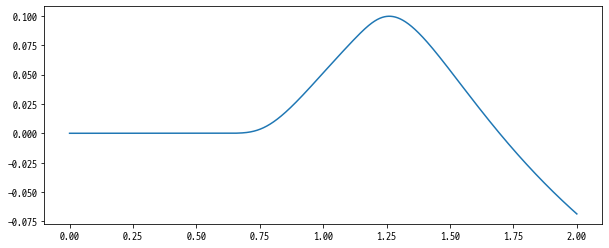

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

#ax.plot(t, (n[:, 20] + k[:, 20]) - (n[:, 80] + k[:, 80]))
ax.plot(t, space.n[:, 0, 0] + space.n[:, 1, 0] - space.n[:, 0, -1] - space.n[:, 1, -1])